<h1>Modelo 1: Red neuronal densa (MLP)</h1>

<p>Este modelo funciona bajo una idea simple: Usar el embedding medio de cada texto (title + abstract) y con este embedding medio realizar la clasificacion multiclase mediante una red neuronal de capa densa</p>

<p>La arquitectura de esta red se compone de 3 capas:</p>

<ol>
    <li>Capa de entrada (768 neuronas)</li>
    <li>Capa intermedia ((1.5 x 768) neuronas)</li>
    <li>Capa de salida con sigmoide en cada una de las salidas individuales en vez de softmax para la clasificacion (4 neuronas)</li>
</ol>

In [ ]:
## Descomentar si se está trabajando desde Google Colab

#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


<p>Para pasar los textos a embeddings, usamos la libreria transformers con BertTokenizer para a creación de los mismos, estoo nos da una matriz de dimensiones N x d_model (siendo N el numero de tokens del texto), luego le evaluamos la media a traves de estos N vectores, dandonos al final el vector de embedding medio con dimensiones d_model</p>

Nota: d_model en el caso de Bert es 768

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Cargar tokenizer y modelo
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Mover modelo a GPU (Esto solo para dispositivos que lo tengan)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Tokenizamos un ejemplo
text = "This is an example sentence."
inputs = tokenizer(text, return_tensors="pt").to(device)

In [ ]:
# Obtener SOLO embeddings de tokens (sin positional encoding)
with torch.no_grad():
    token_embeddings = model.embeddings.word_embeddings(inputs["input_ids"])

In [ ]:
# Eliminar dimensión batch → (n_tokens, d_model)
token_matrix = token_embeddings.squeeze(0)

# Calculamos embedding promedio en GPU
mean_embedding = token_matrix.mean(dim=0)   # (d_model,)
print("Mean embedding shape:", mean_embedding.shape)

Mean embedding shape: torch.Size([768])


In [10]:
mean_embedding.shape, mean_embedding.dtype

(torch.Size([768]), torch.float32)

<h2>Carga del dataset</h2>

Cargamos el dataset que estába en una carpeta destinada a este reto en Google drive, y se crea la columna text concatenando la columna abstract y la columna title, además, guardamos sus valores en Numpy array's, X e y de modo que sea mas facil usar estas matrices para entrenar el modelo.

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/techespere/dataset.csv", sep=";")
# df = pd.read_csv("../data/dataset.csv", sep=";") ## Descomentar al trabajar en local

In [17]:
df["text"] = (df["title"].fillna("") + " " + df["abstract"].fillna("")).str.strip()

En el caso de este modelo, la idea es entrenarlo solamente con datos que clasifiquen hacia una sola clase de las 4, y luego realizar un fine - tunning del modelo, ahora si usando datos que sean multiclase

In [ ]:
# Filtramos solo las filas con los grupos que nos interesan

valid_groups = ["cardiovascular", "neurological", "hepatorenal", "oncological"]
df_filtered = df[df["group"].isin(valid_groups)].copy()

# Definir X (texto) e y (labels)

X = df_filtered["text"].values
y = df_filtered["group"].values

print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)
print("Clases presentes:", set(y))

Tamaño de X: (2473,)
Tamaño de y: (2473,)
Clases presentes: {'cardiovascular', 'hepatorenal', 'oncological', 'neurological'}


In [ ]:
## Función para obtener el embedding promedio de un texto

def get_mean_embedding(text):
    # Tokenización y envío a GPU
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        # SOLO token embeddings, sin positional encoding
        token_embeddings = model.embeddings.word_embeddings(inputs["input_ids"])
        token_matrix = token_embeddings.squeeze(0)       # (n_tokens, d_model)
        mean_embedding = token_matrix.mean(dim=0)        # (d_model,)
    return mean_embedding.cpu().numpy()  # traer a CPU como numpy

Convertimos X de texto a embeddings medios e y a one hot encoding

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Construir X (mean embedding)

X = np.vstack([get_mean_embedding(text) for text in df_filtered["text"].values])
print("Shape de X:", X.shape)  # (num_samples, d_model=768)

# Construir y (one-hot encoding)
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df_filtered["group"].values.reshape(-1, 1))

print("Shape de y:", y.shape)  # (num_samples, num_classes=4)
print("Clases:", encoder.categories_)

Shape de X: (2473, 768)
Shape de y: (2473, 4)
Clases: [array(['cardiovascular', 'hepatorenal', 'neurological', 'oncological'],
      dtype=object)]


Garantizamos que las etiquetas ya filtradas (es decir, ya sabemos que son datos que tienen clasificacion de una sola clase) sean del mismo tamaño para evitar problemas de sesgos en el modelo.

In [26]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder

# Paso 1: convertir de one-hot a etiquetas enteras
y_labels = np.argmax(y, axis=1)

# Paso 2: aplicar submuestreo
rus = RandomUnderSampler(random_state=42)
X_bal, y_bal_labels = rus.fit_resample(X, y_labels)

# Paso 3: volver a one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_bal = encoder.fit_transform(y_bal_labels.reshape(-1, 1))

print("Shape de X original:", X.shape)
print("Shape de X balanceado:", X_bal.shape)
print("Distribución original:", np.bincount(y_labels))
print("Distribución balanceada:", np.bincount(y_bal_labels))

Shape de X original: (2473, 768)
Shape de X balanceado: (948, 768)
Distribución original: [ 645  533 1058  237]
Distribución balanceada: [237 237 237 237]


Creamos el modelo mediante una funcion

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_multilabel_model(input_dim, n_labels):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(int(1.5*input_dim), activation="relu")(inputs)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_labels, activation="sigmoid")(x)  # sigmoid por salida
    return models.Model(inputs, outputs)

model = build_multilabel_model(input_dim=768, n_labels=4)  # ejemplo: 100 features, 4 etiquetas
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1152)           │       885,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 890,500 (3.40 MB)

 Trainable params: 890,500 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.AUC(name="auc"),
             tf.keras.metrics.Precision(name="precision"),
             tf.keras.metrics.Recall(name="recall")]
)

In [ ]:
from sklearn.model_selection import train_test_split

## Separamos los datos entre entrenamiento y prueba
# División en 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal,
    test_size=0.2,        # 20% para test
    random_state=42,      # semilla reproducible
    stratify=y_bal        # asegura misma proporción de clases en train y test
)

In [37]:
X_test.shape, y_test.shape

((190, 768), (190, 4))

In [32]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - auc: 0.5276 - loss: 1.3888 - precision: 0.2666 - recall: 0.5219 - val_auc: 0.5811 - val_loss: 1.3778 - val_precision: 0.2509 - val_recall: 0.7526
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.5556 - loss: 1.3778 - precision: 0.2683 - recall: 0.7387 - val_auc: 0.6376 - val_loss: 1.3587 - val_precision: 0.2851 - val_recall: 0.6632
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.6001 - loss: 1.3608 - precision: 0.2748 - recall: 0.7396 - val_auc: 0.6673 - val_loss: 1.3472 - val_precision: 0.3538 - val_recall: 0.7263
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.6435 - loss: 1.3473 - precision: 0.3350 - recall: 0.7301 - val_auc: 0.6837 - val_loss: 1.3233 - val_precision: 0.3283 - val_recall: 0.6842
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - auc: 0.6870 - loss: 1.3275 - precision: 0.3437 - recall: 0.7398 - val_auc: 0.7243 - val_loss: 1.2994 - val_precision: 0.3518 - val_recall: 0.7368
Epoch 6/

En la ejecucion de arriba podemos ver que hay un alto accuracy tanto en entrenamiento como en validación, sin embargo, aun no hemos evaluado este modelo con multiclases, por lo que no se puede determinar aun su efectividad (esta evaluacion se hace en el notebook model_MLP_evaluation.ipynb)

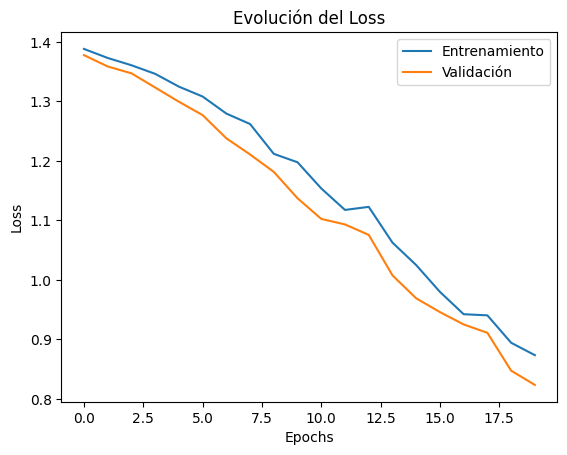

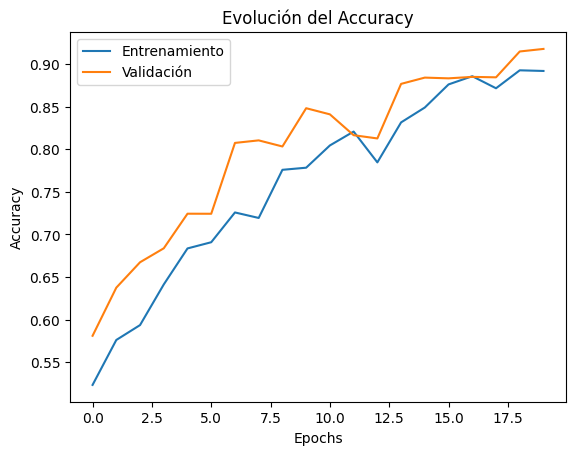

In [ ]:
import matplotlib.pyplot as plt


# Plot del Loss
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.title("Evolución del Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot del Accuracy
plt.plot(history.history["auc"], label="Entrenamiento")
plt.plot(history.history["val_auc"], label="Validación")
plt.title("Evolución del Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


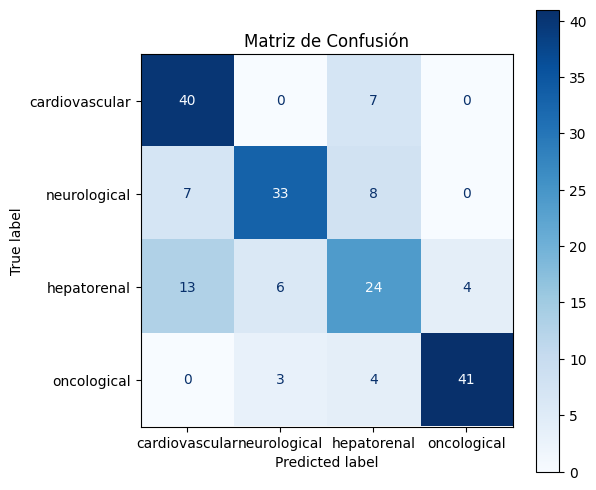

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predecir con el modelo
y_pred_prob = model.predict(X_test)

# Convertir probabilidades a clases (elegir la clase con mayor probabilidad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)  # porque y_test está en one-hot

# Construir matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar matriz de confusión con nombres de clases
labels = ["cardiovascular", "neurological", "hepatorenal", "oncological"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
## Guardamos el modelo para su uso futuro en la evaluacion

model.save("mlp_sigmiod_per_class.h5")

Guardamos los datos de testing para que el desarrollador que está realizando la visualizacion usando V0, pueda tener acceso a los mismos.

In [38]:
import pickle

# Guardar
with open("X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("✅ Archivos guardados: X_test.pkl y y_test.pkl")

# ==========================
# Para cargarlos nuevamente:
# ==========================
with open("X_test.pkl", "rb") as f:
    X_test_loaded = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test_loaded = pickle.load(f)

print("Shapes cargados:", X_test_loaded.shape, y_test_loaded.shape)

✅ Archivos guardados: X_test.pkl y y_test.pkl
Shapes cargados: (190, 768) (190, 4)


Ya tenemos el accuracy del modelo (91,76% en validacion) sin embargo, tambien es importante obtener el f1 - score, especialmente el f1 score weigthed.

Recordemos que estas metricas no son definitivas, pues el modelo aun no ha sido probado contra datos con multiclases

In [ ]:
from sklearn.metrics import f1_score

# Predecir sobre el conjunto de prueba
y_pred_prob = model.predict(X_test)

# Pasar de probabilidades a clases
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular F1-score
f1_macro = f1_score(y_true, y_pred, average="macro")   # Promedio por clase
f1_micro = f1_score(y_true, y_pred, average="micro")   # Promedio global
f1_weighted = f1_score(y_true, y_pred, average="weighted") # Balanceado por soporte

print("F1-macro:", f1_macro)
print("F1-micro:", f1_micro)
print("F1-weighted:", f1_weighted)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
F1-macro: 0.7240126620440157
F1-micro: 0.7263157894736842
F1-weighted: 0.724891759093241
